# DPA Contest v4

## Load traces

In [1]:
import pandas
import pprint

FORMAT_OFFSETS = 'Offsets'
FORMAT_SIZES = 'Sizes in bytes'
FORMAT_STRUCT = 'Struct'

dpacv4_format = pandas.read_csv('dpacv4_format.csv', index_col=0)
pprint.pprint(dpacv4_format)

                   Offsets  Sizes in bytes Struct
Names                                            
DESCRIPTOR_NAME          0              16    16s
TEMPLATE_NAME           16              16    16s
COMM_TYPE               32               2      h
COMM_ORDER              34               2      h
WAVE_DESCRIPTOR         36               4      L
USER_TEXT               40               4      L
RES_DESC1               44               4      L
TRIGTIME_ARRAY          48               4      L
RIS_TIME_ARRAY          52               4      L
RES_ARRAY_1             56               4      L
WAVE_ARRAY_1            60               4      L
WAVE_ARRAY_2            64               4      L
INSTRUMENT_NAME         76              40    40s
WAVE_ARRAY_COUNT       116               4      L
FIRST_VALID_POINT      124               4      L
LAST_VALID_POINT       128               4      L
VERTICAL_GAIN          156               4      f
VERTICAL_OFFSET        160               4      f


In [2]:
dpacv4_format.loc['COMM_ORDER']

Offsets           34
Sizes in bytes     2
Struct             h
Name: COMM_ORDER, dtype: object

In [3]:
import pprint
import glob

# define root directory of all traces (*.bz2)
bz2_trace_directory = "../dpacv4_data/"
# get file names of all traces
bz2_files = [f for f in glob.glob(bz2_trace_directory + "**/*.bz2", recursive=True)]
bz2_files = sorted(bz2_files)
pprint.pprint("number of trace files = %d" % len(bz2_files))

'number of trace files = 5000'


In [4]:
import bz2
import struct
import numpy

DPACV4_OFFSET = 11

def decode_trace(binary_data):
    comm_order_series = dpacv4_format.loc['COMM_ORDER']
    comm_order = struct.unpack('>%s' % comm_order_series[FORMAT_STRUCT],
                               binary_data[comm_order_series[FORMAT_OFFSETS] : comm_order_series[FORMAT_OFFSETS]+comm_order_series[FORMAT_SIZES]])[0],
    if 0 == comm_order:
        byteorder = '>'
    else:
        byteorder = '<'
    header = {}
    for name in dpacv4_format.index:
        series = dpacv4_format.loc[name]
        header[name] = struct.unpack('%s%s' % (byteorder, series[FORMAT_STRUCT]),
                                     binary_data[series[FORMAT_OFFSETS] : series[FORMAT_OFFSETS]+series[FORMAT_SIZES]])[0]
    data = binary_data[header['WAVE_DESCRIPTOR'] + 1: ]
    pprint.pprint('unpack data length = %d' % len(data))
    if 0 == header['COMM_TYPE']:
        iter_unpack = struct.iter_unpack('%sb' % byteorder, data)
    else:
        iter_unpack = struct.iter_unpack('%sh' % byteorder, data)
    trace = numpy.asarray([x[0] for x in iter_unpack])
        
    assert(len(trace) == header['WAVE_ARRAY_COUNT'])
    return header, trace

HEADER = 'header'
FILENAME = 'filename'
TRACE = 'trace'

def load_trace_file(filename):    
    pprint.pprint('bz2_files = %s' % filename)
    with bz2.BZ2File(filename=filename, mode='r') as fd:
        raw_data = fd.read()
    pprint.pprint(len(raw_data))
    trace_header, trace_data = decode_trace(raw_data[DPACV4_OFFSET:])
    return {FILENAME:filename, HEADER: trace_header, TRACE: trace_data}

In [5]:
# extract data files
trace_indexes = [25, 30, 35]

trace_data = [load_trace_file(bz2_files[idx]) for idx in trace_indexes]
for data in trace_data:
    pprint.pprint('********* %s' % data[FILENAME])
    pprint.pprint(data[HEADER])
    pprint.pprint('data length = %d' % len(data[TRACE]))

'bz2_files = ../dpacv4_data/k00/DPACV42_000025.trc.bz2'
1704760
'unpack data length = 1704402'
'bz2_files = ../dpacv4_data/k00/DPACV42_000030.trc.bz2'
1704760
'unpack data length = 1704402'
'bz2_files = ../dpacv4_data/k00/DPACV42_000035.trc.bz2'
1704760
'unpack data length = 1704402'
'********* ../dpacv4_data/k00/DPACV42_000025.trc.bz2'
{'COMM_ORDER': 1,
 'COMM_TYPE': 0,
 'DESCRIPTOR_NAME': b'WAVEDESC\x00\x00\x00\x00\x00\x00\x00\x00',
 'FIRST_VALID_POINT': 0,
 'INSTRUMENT_NAME': b'LECROYWR6100A\x00\x00\x00EH\x00\x00\x00\x00\x00\x00'
                    b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
                    b'6\x1b\x1a\x00',
 'LAST_VALID_POINT': 1704401,
 'NOMINAL_BITS': 8,
 'RES_ARRAY_1': 0,
 'RES_DESC1': 0,
 'RIS_TIME_ARRAY': 0,
 'TEMPLATE_NAME': b'LECROY_2_3\x00\x00\x00\x00\x00\x00',
 'TRIGTIME_ARRAY': 0,
 'USER_TEXT': 0,
 'VERTICAL_GAIN': 0.0004655862576328218,
 'VERTICAL_OFFSET': -0.004252725746482611,
 'WAVE_ARRAY_1': 1704402,
 'WAVE_ARRAY_2': 0,
 'WAVE_ARRAY_COUN

## Visualizations

### Visualizations the raw traces

<IPython.core.display.Javascript object>


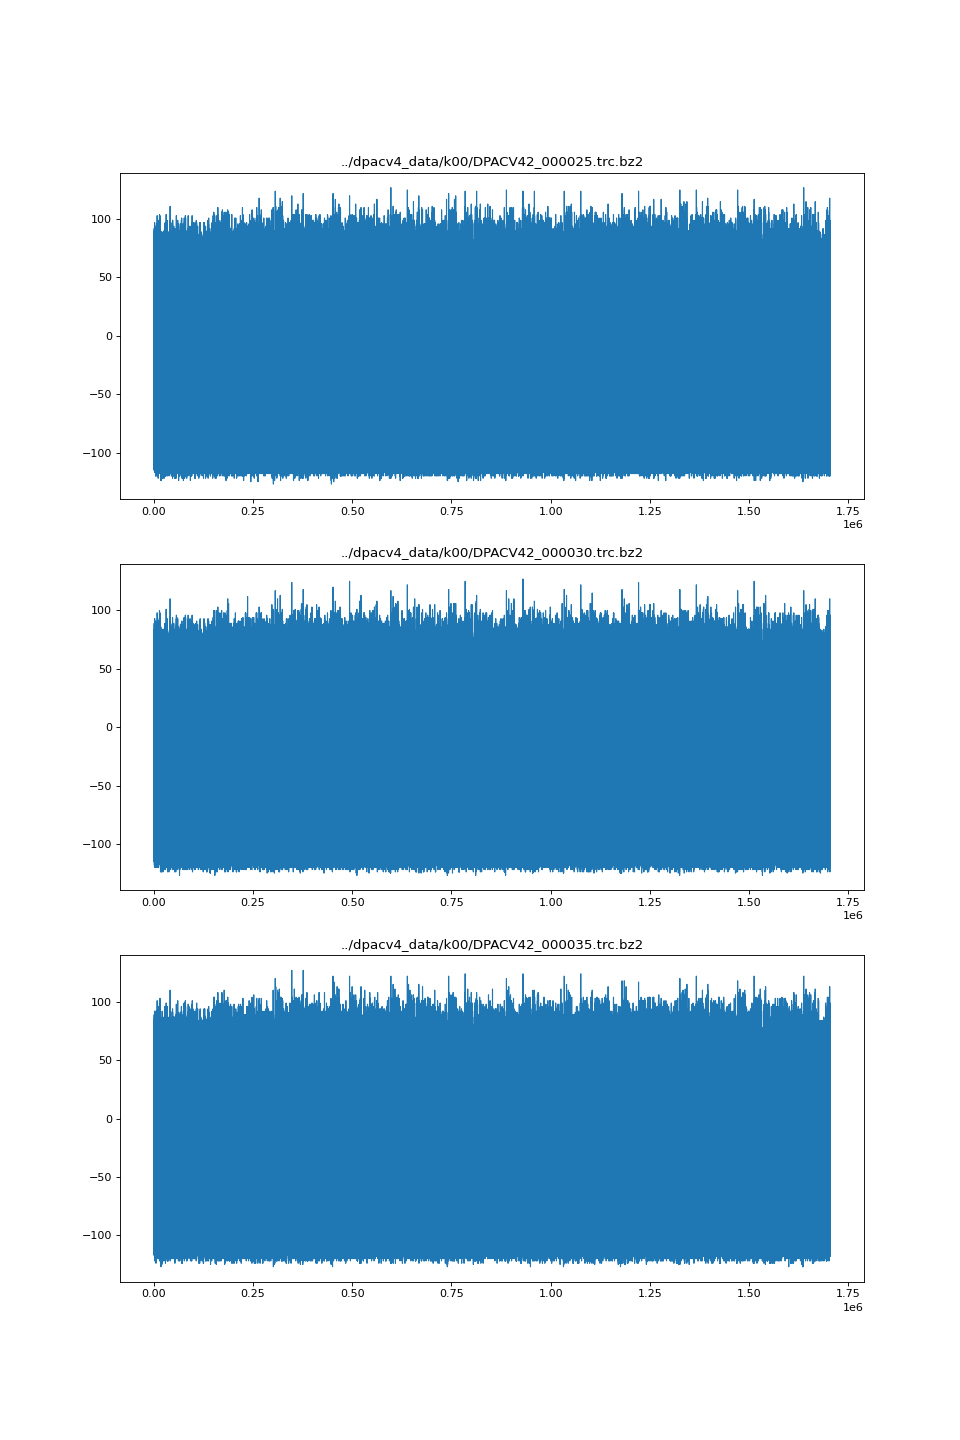

In [6]:
%matplotlib notebook 

from matplotlib import pyplot as plt

plt.figure(figsize=(12, 6 * len(trace_data)), dpi=80)
subplot_id = 1
for data in trace_data:
    plt.subplot(len(trace_data) * 100 + 10 + subplot_id)
    plt.plot(range(len(data[TRACE])), data[TRACE], linewidth=1)
    plt.title(data[FILENAME])
    #plt.scatter(range(len(draw_trace)), draw_trace, s=1)
    # for the next subplot
    subplot_id = subplot_id + 1
plt.show()

### Visualizations in Fourrier space
We visualize the complete sequence of data first

In [7]:
FOURRIER = 'fourrier'
for data in trace_data:
    # run ifftshift for positioning the time zero for the first element
    data[FOURRIER] = numpy.fft.fft(numpy.fft.ifftshift(data[TRACE]))

<IPython.core.display.Javascript object>


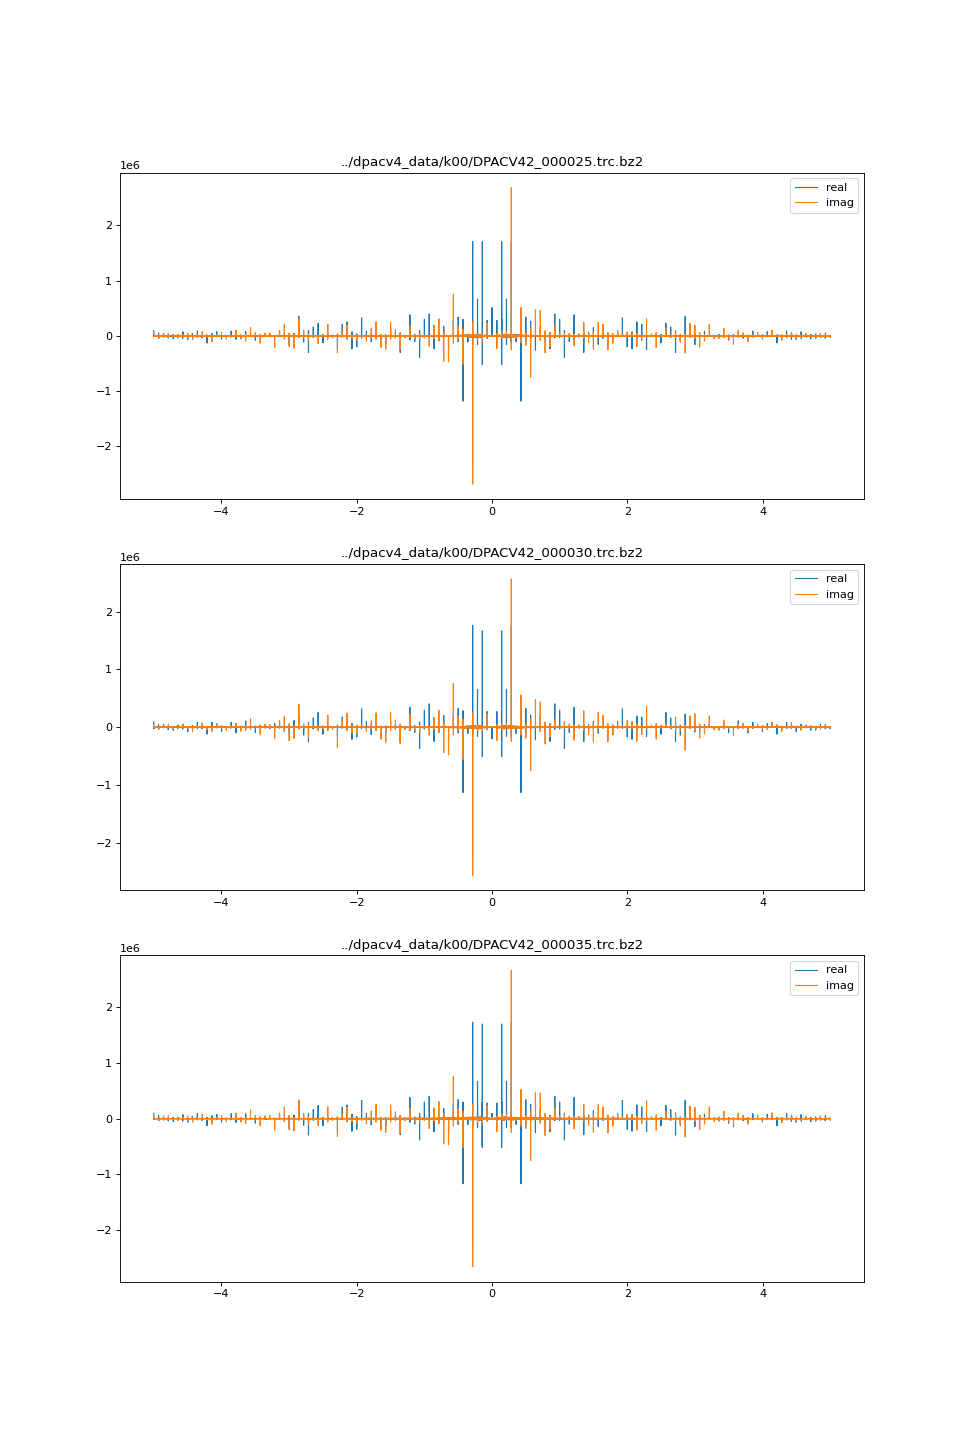

In [8]:
dt = 0.1

plt.figure(figsize=(12, 6 * len(trace_data)), dpi=80)
subplot_id = 1
for data in trace_data:
    plt.subplot(len(trace_data) * 100 + 10 + subplot_id)   
    # calculate frequencies fftfreq
    freq = numpy.fft.fftfreq(len(data[TRACE]), d=dt)
    x = numpy.fft.fftshift(freq)
    # run fftshift for positioning the frequency zero in center
    y = dt * numpy.fft.fftshift(data[FOURRIER])
    
    plt.plot(x, y.real, linewidth=1, label='real')
    plt.plot(x, y.imag, linewidth=1, label='imag')
    plt.title(data[FILENAME])
    plt.legend()

    subplot_id = subplot_id + 1
plt.show()    